# M.2. TIPS

### DRW / UChicago Prep Course

#### Chicago, Summer 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# TIPS

**Treasury Inflation Protected Securities** (TIPS)
- Treasury notes and bonds (no bills)
- Semiannual coupon
- Issued since 1997

### Inflation protection

TIPS provide a hedge against inflation.
- Face value is scaled by CPI
- Coupon rate is fixed
- Fixed coupon rate multiplies the (CPI-adjusted) face-value, which leads to an inflation-adjusted coupon

In [1]:
import pandas as pd

In [2]:
QUOTE_DATE = '2024-04-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
data = pd.read_excel(filepath_rawdata,sheet_name='quotes').set_index('KYTREASNO')

In [3]:
from cmds.bond_calcs import crsp_data_calculate_ytm
ytm_calcs = crsp_data_calculate_ytm(data)
data['ytm'] = ytm_calcs['ytm']

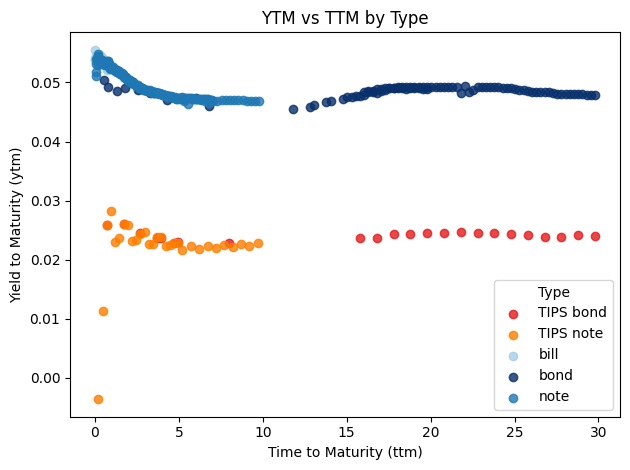

In [4]:
from cmds.plot_utils import scatter_by_type
from cmds.config import COLOR_MAP 

ax = scatter_by_type(
    data,
    x='ttm',
    y='ytm',
    color_map=COLOR_MAP,
    xlabel='Time to Maturity (ttm)',
    ylabel='Yield to Maturity (ytm)',
    title='YTM vs TTM by Type',
    alpha=0.8,
)


***

In [5]:
DATE = '2025-04-30'
FILEIN_TS = f'../data/treasury_ts_crsp_{DATE}.xlsx'
df_ytm = pd.read_excel(FILEIN_TS,sheet_name='ytm').set_index('caldt')
df_ttm = pd.read_excel(FILEIN_TS,sheet_name='ttm').set_index('caldt')
df_info = pd.read_excel(FILEIN_TS,sheet_name='info').set_index('Unnamed: 0').T

In [6]:
ttm = df_ttm.iloc[:, 0]
df_plot = df_ytm.copy()

# grab the first index value (or, if you actually want a column, use info['itype'].iloc[0])
first = df_info['itype'][0]

# decide the new column order in one line
new_cols = (['nominal','TIPS'] if first in (1, 2)
            else ['TIPS','nominal'] if first in (11, 12)
            else None)

if new_cols is None:
    raise ValueError(f"Unexpected info index: {first!r}")

# apply the renaming
df_plot.columns = new_cols


/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_55041/1160865681.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first = df_info['itype'][0]


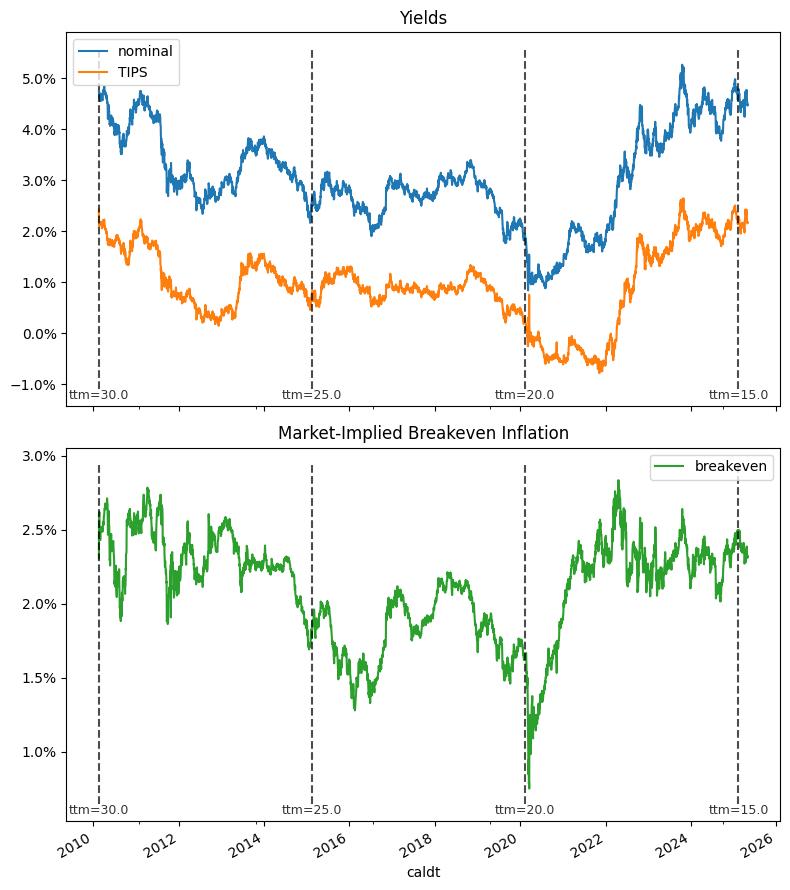

In [7]:
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.pyplot as plt

tol = 0.01
max_val = ttm.max()
multiples = np.arange(5, max_val + 5, 5)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 9))

# ─── Top panel: your two curves ───
df_plot.plot(ax=ax1)
ymin1, ymax1 = ax1.get_ylim()
for m in multiples:
    mask = np.isclose(ttm.values, m, atol=tol)
    if not mask.any():
        continue
    loc = ttm.index[mask][0]
    ax1.vlines(loc, ymin1, ymax1, colors='black', linestyles='--', alpha=0.7)
    ax1.text(loc, ymin1, f"ttm={m}", rotation=0,
             va='top', ha='center', fontsize=9, alpha=0.8)

ax1.legend()
ax1.set_title("Yields")
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=1))

# ─── Bottom panel: the breakeven ───
breakeven = df_plot.iloc[:, 0] - df_plot.iloc[:, 1]
breakeven.plot(ax=ax2, label='breakeven', color='tab:green')  # new color here
ymin2, ymax2 = ax2.get_ylim()
for m in multiples:
    mask = np.isclose(ttm.values, m, atol=tol)
    if not mask.any():
        continue
    loc = ttm.index[mask][0]
    ax2.vlines(loc, ymin2, ymax2, colors='black', linestyles='--', alpha=0.7)
    ax2.text(loc, ymin2, f"ttm={m}", rotation=0,
             va='top', ha='center', fontsize=9, alpha=0.8)

ax2.legend()
ax2.set_title("Market-Implied Breakeven Inflation")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=1))

plt.tight_layout()
plt.show()


***

## Market Expectations

In [8]:
rawdata = pd.read_excel('../data/economic_data.xlsx',sheet_name='data').set_index('date')

FREQ = 4

if FREQ == 4:
    FREQcode = 'QE'
elif FREQ == 1:
    FREQcode = 'Y'
elif FREQ==12:
    FREQcode = 'M'

data = rawdata.resample(FREQcode).agg('last')
data.index = data.index - pd.tseries.offsets.BDay(1)

data_econ = data
inflation = (data['CPI-Core']/data['CPI-Core'].shift(1) -1 ) * FREQ

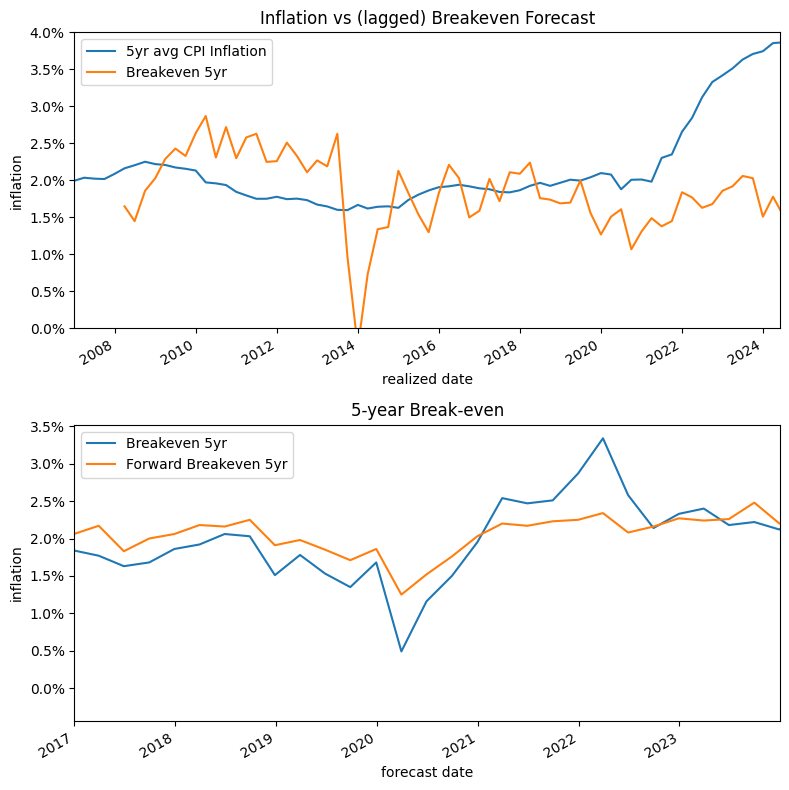

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# --- prepare your data (as you already have) ---
inflation_expectations = pd.concat([
    inflation.rolling(FREQ*5).mean(),
    (data_econ['Breakeven 5yr']/100).shift(5*FREQ)
], axis=1)
inflation_expectations.rename(
    columns={'CPI-Core':'5yr avg CPI Inflation'},
    inplace=True
)

# --- make the wide, 2×1 figure ---
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(8, 8),     # wider than default
    sharex=False,        # each panel has its own x‐range
    gridspec_kw={'height_ratios': [1,1]}
)

# Top panel: realized vs lagged breakeven
inflation_expectations.plot(
    ax=ax1,
    xlim=('2007-01-01','2024-05-31'),
    ylim=(0, .04),
    xlabel='realized date',
    ylabel='inflation',
    title='Inflation vs (lagged) Breakeven Forecast'
)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))

# Bottom panel: breakeven series
(data_econ[['Breakeven 5yr','Forward Breakeven 5yr']] / 100).plot(
    ax=ax2,
    xlim=('2017-01-01','2023-12-31'),
    xlabel='forecast date',
    ylabel='inflation',
    title='5-year Break-even'
)
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))

# tighten and show
plt.tight_layout()
plt.show()
